In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from sklearn.preprocessing import normalize

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Import Data

In [5]:
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')
ble = read_ble('../Data/ble.csv')

In [6]:
data_1 = read_data('../Data/rssi5.csv')
data_2 = read_data('../Data/rssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [7]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [8]:
data = pd.concat([data_1, data_2, test_2], axis=0)
test = pd.concat([test_1], axis=0)

In [9]:
test.shape

(8458, 19)

## Train Validation Split

In [10]:
train, validation = train_validation_split(data)

In [11]:
print(train.shape)
print(validation.shape)

(118926, 19)
(13215, 19)


In [12]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 30

    data = data.sort_values("time")
    data_rolled = data.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill()
    data_imputed.reset_index(inplace=True)
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [13]:
train_imputed = impute(train)
validation_imputed = impute(validation)
test_imputed = impute(test)

In [14]:
train_imputed[scanners] = normalize(train_imputed[scanners] + 100)
validation_imputed[scanners] = normalize(validation_imputed[scanners] + 100)
test_imputed[scanners] = normalize(test_imputed[scanners] + 100)

In [15]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,T1_1,0,0.116910,0.253464,0.204979,0.171550,0.217839,0.348638,0.322005,0.106991,...,0.027492,0.389544,0.213533,0.195722,0.007555,0.328062,0.291858,0.115746,29.93425,9.659024
1,T1_1,1,0.116853,0.253340,0.204879,0.171467,0.217732,0.348468,0.321847,0.106939,...,0.027479,0.389354,0.213429,0.195627,0.007551,0.327902,0.291715,0.115690,29.93425,9.659024
2,T1_1,2,0.112563,0.244039,0.197357,0.165171,0.209738,0.335674,0.310031,0.103013,...,0.026470,0.375059,0.205593,0.328012,0.007274,0.315863,0.281005,0.111442,29.93425,9.659024
3,T1_1,3,0.112781,0.244513,0.197740,0.165493,0.210146,0.336327,0.304305,0.103213,...,0.026521,0.375788,0.205993,0.328649,0.007288,0.316477,0.281552,0.111659,29.93425,9.659024
4,T1_1,4,0.112997,0.244981,0.198119,0.165809,0.210548,0.336970,0.304887,0.103410,...,0.026572,0.376507,0.206387,0.329278,0.007302,0.310985,0.282090,0.111872,29.93425,9.659024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118921,V1_9,31037,0.270363,0.158171,0.209669,0.325539,0.165528,0.099317,0.220704,0.408303,...,0.187599,0.099317,0.303468,0.261167,0.336574,0.204151,0.066211,0.364162,8.17867,5.282130
118922,V1_9,31039,0.271111,0.158609,0.210249,0.326440,0.165986,0.099592,0.221315,0.409433,...,0.199184,0.099592,0.304308,0.261890,0.328284,0.195495,0.066395,0.365170,8.17867,5.282130
118923,V1_9,31040,0.271915,0.159080,0.210873,0.308540,0.166479,0.122084,0.221971,0.410647,...,0.199774,0.099887,0.307061,0.262666,0.329258,0.196075,0.066591,0.366253,8.17867,5.282130
118924,V1_9,31042,0.271484,0.138512,0.210539,0.308051,0.166215,0.121891,0.221620,0.421077,...,0.199458,0.099729,0.306574,0.262250,0.328736,0.195764,0.066486,0.365672,8.17867,5.282130


## Model Training

In [16]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [17]:
optimizer = tf.keras.optimizers.Adam(0.00001)
loss = "mse"
metrics = ["mae", "mse"]
batch_size = 32
epochs = 10000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss')
]

inputs = tf.keras.Input(shape=(17,))
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(128, activation='relu')(inputs)
y = tf.keras.layers.Dense(64, activation='relu')(y)
y = tf.keras.layers.Dense(32, activation='relu')(y)
y = tf.keras.layers.Dense(16, activation='relu')(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
______________________________________________________________________________________________

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 118926 samples, validate on 8458 samples
Epoch 1/10000
118926/118926 [==============================] - 5s 39us/sample - loss: 160.9472 - mae: 10.1460 - mse: 160.9474 - val_loss: 62.0340 - val_mae: 5.6058 - val_mse: 62.0340
Epoch 2/10000
118926/118926 [==============================] - 4s 35us/sample - loss: 31.1663 - mae: 4.2062 - mse: 31.1664 - val_loss: 15.3821 - val_mae: 3.2282 - val_mse: 15.3821
Epoch 3/10000
118926/118926 [==============================] - 4s 32us/sample - loss: 9.7778 - mae: 2.4875 - mse: 9.7779 - val_loss: 2.6701 - val_mae: 1.3477 - val_mse: 2.6701
Epoch 4/10000
118926/118926 [==============================] - 4s 34us/sample - loss: 2.9962 - mae: 1.4109 - mse: 2.9962 - val_loss: 2.2331 - val_mae: 1.2180 - val_mse: 2.2331
Epoch 5/10000
118926/118926 [==============================] - 4s 31us/sample - loss: 2.4044 - mae: 1.2195 - mse: 2.4044 - val_loss: 2.0964 - val_mae: 1.1587 - val_mse: 2.0964
Epoch 6/10000
118926/118926 [==============================

Epoch 47/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.6911 - mae: 0.5752 - mse: 0.6911 - val_loss: 1.6327 - val_mae: 1.0023 - val_mse: 1.6327
Epoch 48/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.6781 - mae: 0.5686 - mse: 0.6781 - val_loss: 1.6223 - val_mae: 1.0027 - val_mse: 1.6223
Epoch 49/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.6656 - mae: 0.5624 - mse: 0.6656 - val_loss: 1.6434 - val_mae: 1.0065 - val_mse: 1.6434
Epoch 50/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.6536 - mae: 0.5566 - mse: 0.6536 - val_loss: 1.6040 - val_mae: 0.9967 - val_mse: 1.6040
Epoch 51/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.6418 - mae: 0.5506 - mse: 0.6418 - val_loss: 1.6016 - val_mae: 0.9947 - val_mse: 1.6016
Epoch 52/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.6305 - mae: 0.5449 - mse: 

118926/118926 [==============================] - 3s 29us/sample - loss: 0.3837 - mae: 0.4084 - mse: 0.3837 - val_loss: 1.3311 - val_mae: 0.8897 - val_mse: 1.3311
Epoch 94/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.3804 - mae: 0.4062 - mse: 0.3804 - val_loss: 1.2974 - val_mae: 0.8755 - val_mse: 1.2974
Epoch 95/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.3770 - mae: 0.4041 - mse: 0.3770 - val_loss: 1.2950 - val_mae: 0.8752 - val_mse: 1.2950
Epoch 96/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.3738 - mae: 0.4021 - mse: 0.3738 - val_loss: 1.3142 - val_mae: 0.8823 - val_mse: 1.3142
Epoch 97/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.3705 - mae: 0.4003 - mse: 0.3705 - val_loss: 1.3099 - val_mae: 0.8771 - val_mse: 1.3099
Epoch 98/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.3675 - mae: 0.3983 - mse: 0.3675 - val_lo

118926/118926 [==============================] - 3s 29us/sample - loss: 0.2655 - mae: 0.3330 - mse: 0.2655 - val_loss: 1.3455 - val_mae: 0.8671 - val_mse: 1.3455
Epoch 140/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.2637 - mae: 0.3317 - mse: 0.2637 - val_loss: 1.3186 - val_mae: 0.8553 - val_mse: 1.3186
Epoch 141/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.2620 - mae: 0.3304 - mse: 0.2620 - val_loss: 1.3327 - val_mae: 0.8605 - val_mse: 1.3327
Epoch 142/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.2602 - mae: 0.3295 - mse: 0.2602 - val_loss: 1.3217 - val_mae: 0.8609 - val_mse: 1.3217
Epoch 143/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.2587 - mae: 0.3284 - mse: 0.2587 - val_loss: 1.3080 - val_mae: 0.8495 - val_mse: 1.3080
Epoch 144/10000
118926/118926 [==============================] - 3s 29us/sample - loss: 0.2568 - mae: 0.3270 - mse: 0.2568 - v

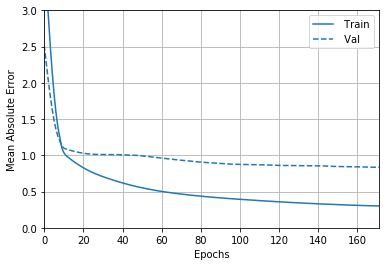

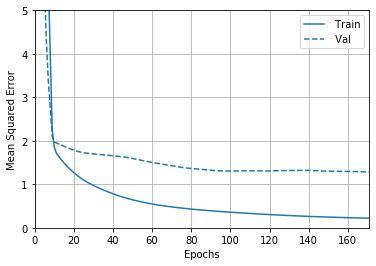

In [20]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('Mean Squared Error')

plt.show()

## Model Validation

In [21]:
def inv_scale(y):
    ret_y = np.copy(y)
    ret_y[:, 0] = ret_y[:, 0] * 33.5
    ret_y[:, 1] = ret_y[:, 1] * 16.8
    return ret_y

def average_distance_error(preds, y_test, scaled=False):
    if scaled:
        preds = inv_scale(preds)
        y_test = inv_scale(y_test)
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=1)))

13215/1 - 0s - loss: 0.3475 - mae: 0.4372 - mse: 0.4649
Validation loss: 0.46485586705202864
Mean absolute error: 0.43717876
Mean squared error: 0.46485576
Average distance error: 0.7238939045012075


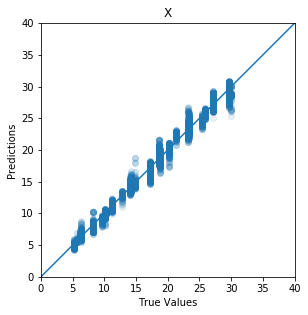

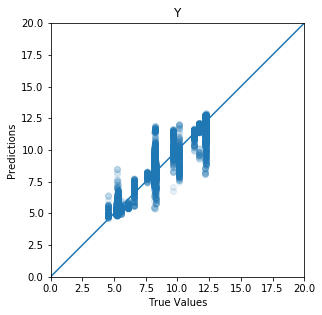

In [22]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Validation loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

## Model Testing

8458/1 - 0s - loss: 1.1302 - mae: 0.8372 - mse: 1.2880
Test loss: 1.2879642582540114
Mean absolute error: 0.8371533
Mean squared error: 1.2879643
Average distance error: 1.384118464566376


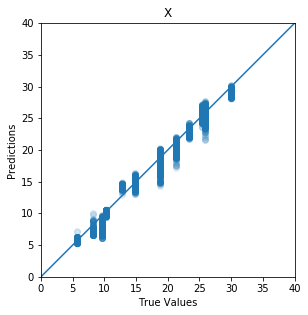

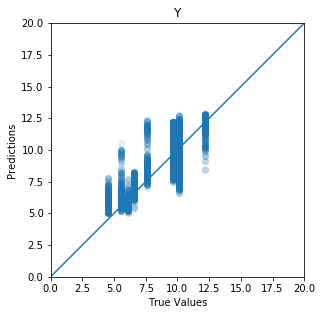

In [23]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

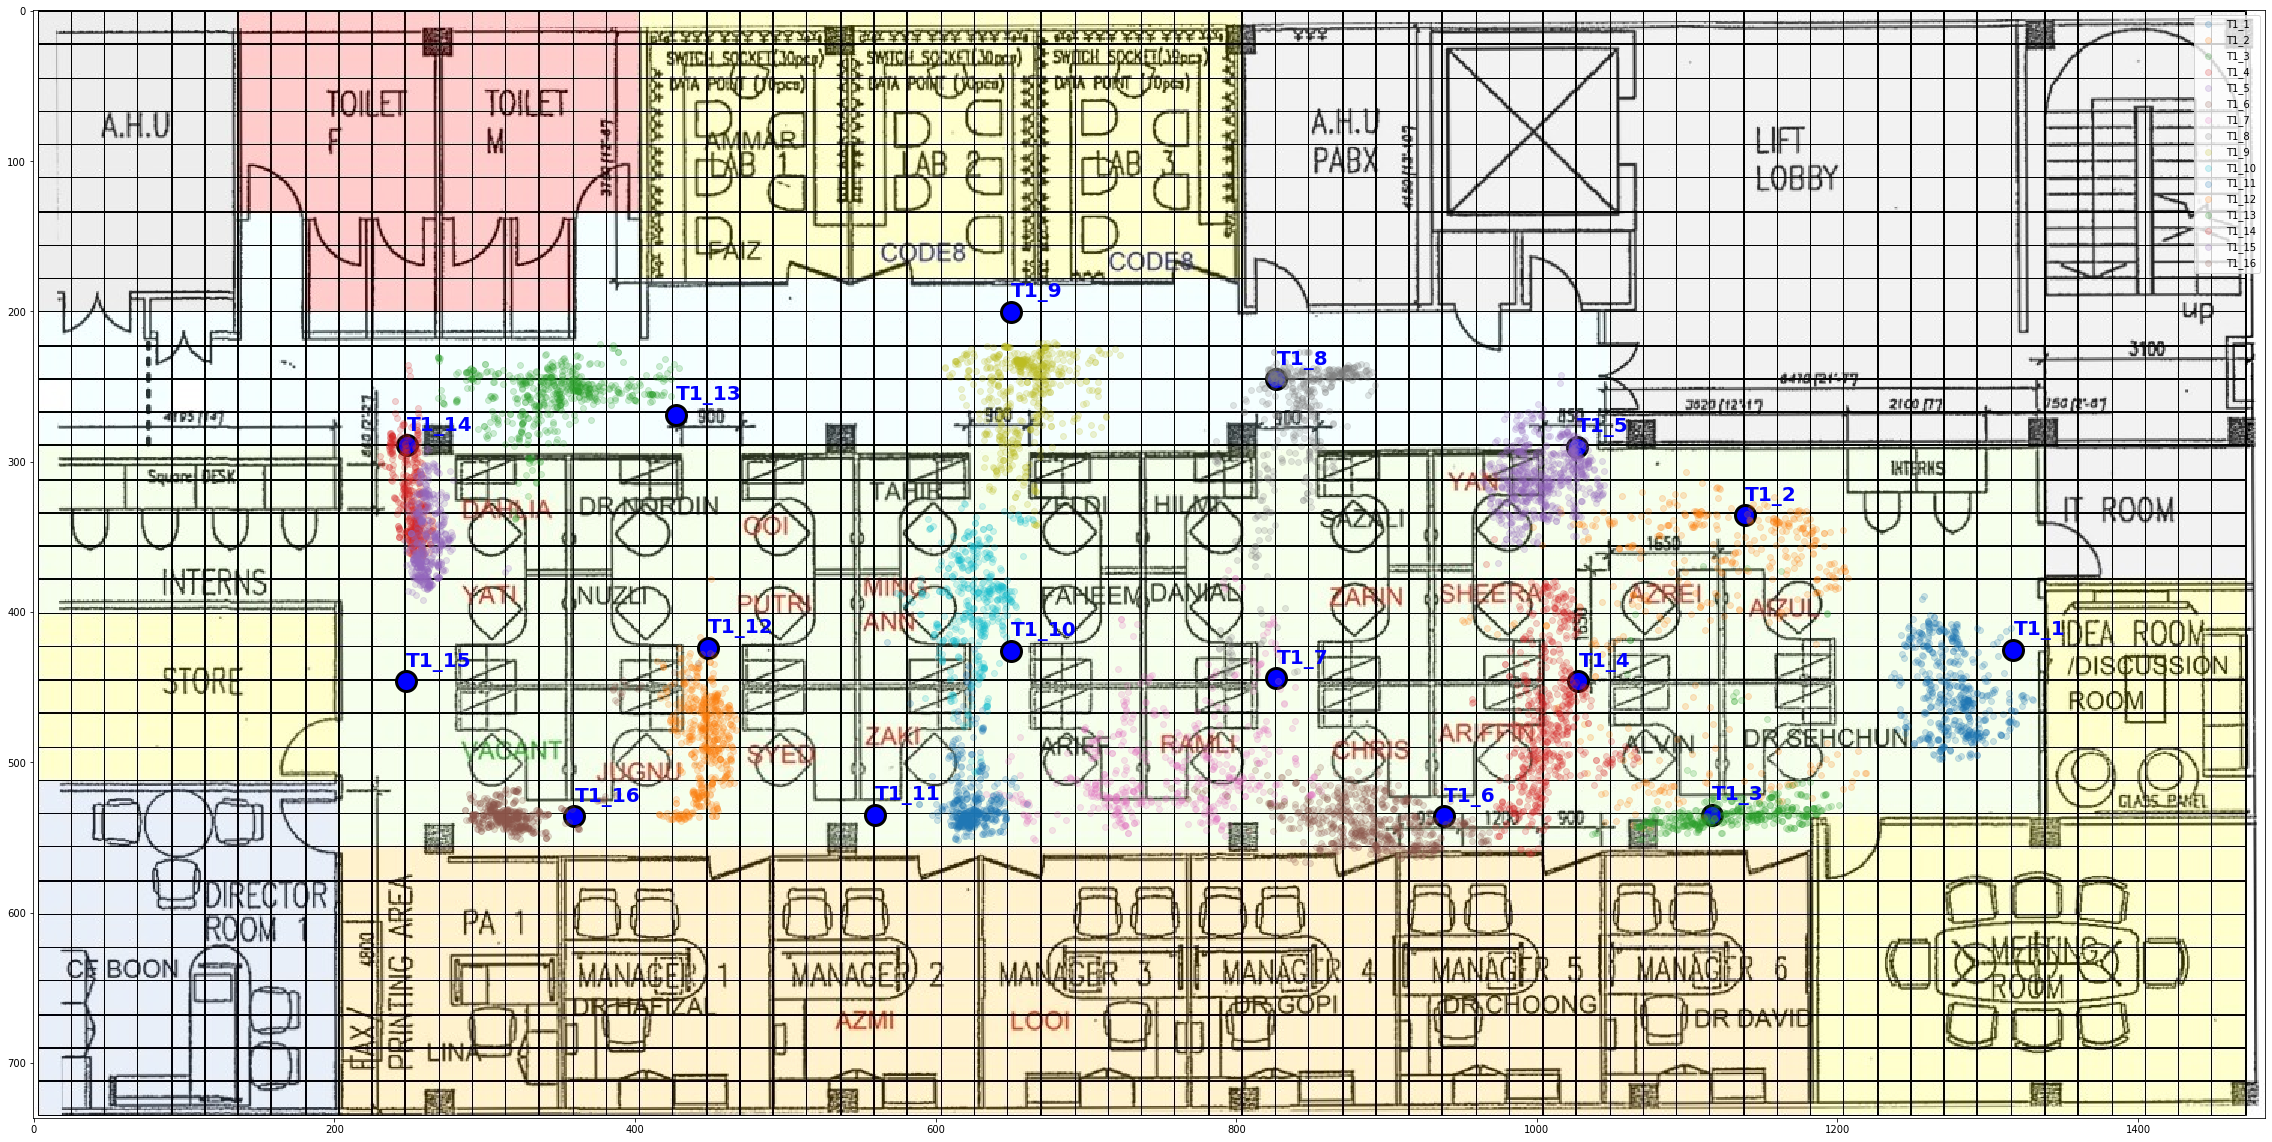

In [24]:
img =  mpimg.imread('../Map/main.png')
fingerprint_color = "r"
testdata_color = "b"
plt.figure(figsize=(40,40))
plt.imshow(img)

labels = ["V1_23", "V1_24", "V1_32", "V1_22", "V1_14", "V1_13", "V1_12", "V1_21", "V1_29", "V1_30", "V1_31", "V1_11", "V1_20", "V1_28", "V1_10", "V1_19", "V1_27", "V1_9", "V1_8", "V1_18", "V1_26"]
x = [27.151600, 29.594400, 29.689400, 23.153700, 23.169100, 20.171700, 17.173201, 18.712299, 18.691700, 23.244200, 27.133301, 14.063600, 14.159800, 14.250300, 11.176600, 10.162500, 10.141900, 8.178670, 5.180690, 6.164600, 6.255650]
y = [8.159480, 8.172020, 11.286000, 8.250140, 5.247920, 5.121330, 5.217130, 8.227330, 12.230300, 12.253700, 11.717700, 5.312350, 8.203950, 12.207500, 5.297530, 8.183420, 12.186400, 5.282130, 5.266730, 8.274090, 12.166400]
x = np.array(x) * 44
y = np.array(y) * 44

testLabels = ["T1_1", "T1_2", "T1_3", "T1_4", "T1_5", "T1_6", "T1_7", "T1_8", "T1_9", "T1_10", "T1_11", "T1_12", "T1_13", "T1_14", "T1_15", "T1_16"]
testX = [29.934250, 25.877805, 25.372470, 23.355726, 23.333564, 21.316819, 18.790348, 18.790348, 14.779021, 14.779021, 12.717952, 10.191480, 9.703916, 5.648265, 5.626103, 8.174736]
testY = [9.659024, 7.630801, 12.155781, 10.139037, 6.593112, 12.177943, 10.094712, 5.573659, 4.554205, 9.673634, 12.155781, 9.629310, 6.105547, 6.570950, 10.139037, 12.177943]
testX = np.array(testX) * 44
testY = np.array(testY) * 44

# plt.scatter(x, y, s=400, c=fingerprint_color, edgecolors="black", linewidths=3)
plt.scatter(testX, testY, s=400, c=testdata_color, edgecolors="black", linewidths=3)

# for i in range(len(labels)):
#     plt.annotate(labels[i], (x[i], y[i] - 10), fontsize=20, color=fingerprint_color, weight='bold')

for j in range(len(testLabels)):
    plt.annotate(testLabels[j], (testX[j], testY[j] - 10), fontsize=20, color=testdata_color, weight='bold')

for i in range(len(testLabels)):
    loc = testLabels[i]
    test_loc = test_imputed[test_imputed['location'] == loc]
    X_loc = test_loc[scanners].values
    locs = model.predict(X_loc) * 44
    plt.scatter(locs[:, 0], locs[:, 1], alpha=0.2, label=testLabels[i])
plt.legend()